In [84]:
# SVD and Pseudo Inverse
# Author: Zhang Su (Teaching Assistant)
# Using python3, numpy, matplotlib
# 26 June 2020

In [85]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// There are too many equations, I have to enable the auto-numbering feature of Mathjax.
// As a consequence, the numbering of equations may be reset for each jupyter cell.
// But the hyperlinks of the numbers should prevent the confusion.

<IPython.core.display.Javascript object>

# Learning Outcome

By the end of this material, you should be able to:

+ Describe the relations among the four fundamental spaces.
+ Describe the formation of $U$, $\Sigma$, and $V$ factors of a SVD, i.e.,  the correspondences between rows/columns and the four fundamental spaces.
+ Carry out SVD using Numpy routines.
+ Implement your own routine to calculate the condition number and pseudo inverse.


Note: 
1. If you occasionally double clicked a textual cell, the display would change to markdown source code. To reverse, simply click anywhere of that markdown cell,  and then click **Run** in the top manu.
2. Sometimes the notebook may not be responding. That is caused by the failure of jupyter kernel. To repair, try clicking **Kernel** in the top manu, then clicking **Reconnect**. 
3. Section Takeaways summarizes useful tips, e.g., holes of Python to avoid, if any.
4. Section Practice reflect the learning outcomes. You are expected to solve them based on your understanding on the lecture notes alone with the coding skills learned from this demo.

## If you just opened the demo, please manually run the cell one-by-one to show the plots correctly!

## Kindly click "Trust" Button on the top right of the page (as shown below ), or the auto equation numbering will be unavailable.
![](img/trust.png)

# Table of contents <a name="Table_of_Content"></a>
+ [Recap of Several Groundings](#RSG)
+ (8.4.1) [SVD](#WSVD)
+ (8.4.5) [Importance of SVD](#PSVD)
+ (interest) [Geometric Interpretation of SVD](#GISVD)
+ (8.4.3) [Condition Number](#CN)
+ (8.4.4) [Pseudo Inverse](#PI)
+ [Takeaways](#Takeaways)

Today we have a busy demo, hope you enjoy :)



Okay, let's import libraries and define some helper functions!

In [76]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pylab import *

np.set_printoptions(suppress=True) # To suppress the scientific notation of Q when printing.

# This makes the plot interactive, by which we can rotate the plot!
%matplotlib notebook 

def construct_Sigma(signular_values, size):
# This function establish the m-by-n Sigma matrix from the singular value array returned by la.svd()
# The Sigma matrix stores the singular values in its diagonal entries.

    Sigma = np.zeros((size[0], size[1]))
    # Populate Sigma with n x n diagonal matrix
    Sigma[:size[1], :size[1]] = np.diag(signular_values)
    return Sigma

def construct_Lambda(eigen_values, size):
# This function establish the m-by-m or N-by-n Lambda matrix from the eigenvalue array returned by la.eig()
# The Lambda matrix stores the eigen values in its diagonal entries.

    Lambda = np.zeros(size)
    
    if size[1] == len(eigen_values):
        Lambda[:size[1], :size[1]] = np.diag(np.square(eigen_values))
    else:
        Lambda[:len(eigen_values), :len(eigen_values)] = np.diag(np.square(eigen_values))
    
    return Lambda

### Recap of Several Groundings<a name="RSG"></a>
[Return to Table of Content](#Table_of_Content)

We start by covering some groundings that are critical! Part of them are from previous lectures, the rest are from today. If you have no problem on them, you should be no problem for understanding the SVD and its beautifulness. 

* * *
* * *

Given an $m\times n$ matrix $A$, A vector $v$ is in the null space of $A$ (denoted by $Nul(A)$) if:

$$
\begin{equation}
Av = \mathbf{0}. 
\label{eq:right_null}
\end{equation}
$$

A vector $v$ is in the left null space of $A$ (denoted by $Nul(A^T)$) if:
$$
\begin{equation}
v^TA = \mathbf{0}. 
\label{eq:left_null}
\end{equation}
$$

where $\mathbf{0}$ is bold denoting a vector. 

+ Null space $Nul(A)$ is perpendicular to row space $Col(A^T)$, they are the orthogonal complements of $\mathbb{R}^n$.
+ Left null space $Nul(A^T)$ is perpendicular to column space $Col(A)$, they are the orthogonal complements of $\mathbb{R}^m$.
+ $Col(A)$, $Nul(A^T)$, $Col(A^T)$, and $Nul(A)$ are called the [four fundamental spaces](https://ww2.mathworks.cn/en/videos/differential-equations-and-linear-algebra-55-the-big-picture-of-linear-algebra-117460.html).

* * *
* * *


$$
\begin{equation}
Dim (A) = (m, n) 
\label{eq:trick0}
\end{equation}
$$

$$
\begin{equation}
Dim (A^TA) = (n, n) 
\label{eq:trick1}
\end{equation}
$$

$$
\begin{equation}
Dim (AA^T) = (m, m) 
\label{eq:trick2}
\end{equation}
$$


$$
\begin{equation}
Rank(A)= Rank(A^T) = Rank(A^TA)=Rank(AA^T)\leq \min(m, n).\tag{6}
\label{eq:rank}
\end{equation}
$$

$$
\begin{equation}
Col(A)= Col(A^TA). 
\label{eq:same_col}
\end{equation}
$$

$$
\begin{equation}
Col(A^T)= Col(AA^T). 
\label{eq:same_row}
\end{equation}
$$


$$
\begin{equation}
Rank(A) = Dim\, Col(A) = Dim\, Col(A^T) 
\label{eq:beauti}
\end{equation}
$$



$$
\begin{equation}
n = Rank(A)+ Dim Nul(A) = Dim Col(A^T) + Dim Nul(A),
\label{eq:nullity}
\end{equation}
$$

$$
\begin{equation}
m = Rank(A^T)+ Dim Nul(A^T) = Dim Col(A) + Dim Nul(A^T).
\label{eq:nullity_transpose}
\end{equation}
$$

If you have no problemo with all the above facts and equations, then you are ready to go!

* * *
* * *

### What is Singular Value Decomposition<a name="WSVD"></a>
[Return to Table of Content](#Table_of_Content)

**The singular value decomposition (SVD) is sort of a voodoo magic that can find the four fundamental spaces in one go.** It is shown as follows.

![](img/svd.png)
>Figure 1. The singular value decomposition (SVD). Suppose that the rank of $A$ is $r$, then the first $r$ columns of $U$ are the basis of the column space $Col(A)$, the last $m-r$ columns are the basis of left null space $Nul(A^T)$, the first $r$ columns of $V$ are the basis of the row space $Col(A^T)$, and the last $n-r$ columns of $V$ are the basis of the null space $Nul(A)$.

$$
\begin{equation}
   A= U\Sigma V^T=
  \begin{matrix}
    \underbrace{\left[\begin{matrix} u_1 &  u_2 & \dots &  u_r\end{matrix}\right.}& | & 
    \underbrace{\left.\begin{matrix} u_{r+1} & \dots &   u_m\end{matrix}\right]}\\
     U_r\in Col(A) &  &  U_{m-r}\in Nul(A^T)
  \end{matrix}
  \begin{bmatrix}
      \sigma_1 & 0 & \dots & 0 & 0 & \dots & 0 \\
         0 & \sigma_2  & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & \sigma_r  & 0 & \dots & 0 \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 \\
         \dots& & & & &  \\
         0 & 0 & \dots & 0 & 0 & \dots & 0 
  \end{bmatrix}
  \begin{bmatrix}
     v_1^T \\  v_2^T \\ \dots \\  v_r^T \\ \rule[.5ex]{1.5em}{0.4pt}\\
     v_{r+1}^T \\ \dots \\  v_n^T
  \end{bmatrix}
  \begin{matrix}
    \left.\vphantom{\begin{bmatrix}
        v_1^T \\  v_2^T \\ \dots \\  v_r^T 
       \end{bmatrix}}\right\} V^T_r\in Col(A^T) \\ 
    \left.\vphantom{\begin{bmatrix}
       v_{r+1}^T \\ \dots \\  v_n^T 
    \end{bmatrix}}\right\} V^{T}_{n-r}\in Nul(A)
  \end{matrix},\tag{12}
\end{equation}
\label{eq:svd}
$$

where $U$ is the eigenvectors of $AA^T$, i.e.,

$$
\begin{align}
AA^T&=U\Lambda U^{-1}=U\Lambda U^T, 
\label{eq:u}
\end{align}
$$

and $V$ is the Eigenvectors of $A^TA$, i.e.,

$$
\begin{align}
A^TA&=V\Lambda V^{-1}=V\Lambda V^T, 
\label{eq:v}
\end{align}
$$

and 

$$
\begin{align}
\sigma_i=\sqrt{\lambda_i},
\label{eq:s}
\end{align}
$$ 

where $\lambda_i$ is the non-zero eigenvalues (diagonal entries of $\Lambda$ in \eqref{eq:u} or Eq. \eqref{eq:v}) of $AA^T$ or $A^TA$ (the missings are padded using 0s). 

In the cell below, we first carry out the SVD, then we attempt to reconstruct $AA^T$ and $A^TA$ following Eq. \eqref{eq:u} and Eq. \eqref{eq:v}, respectively, and finally examine Eq. \eqref{eq:s}. 

In [83]:
# Define a matrix
A = np.array([[0, 0, 1],
             [1, 2, 1],
              [1, 2, 0],
             [0, 0, 1]], dtype=float)
ATA = A.T.dot(A)
AAT = A.dot(A.T)

print("Rank(A)=", np.ndim(A))
print("Rank(A^TA)=", np.ndim(ATA))
print("Rank(AA^T)=", np.ndim(AAT))
print("\n")


# Singular-value decomposition
U, sigmas, VT = la.svd(A)
V = VT.T


# Reconstruct A
Sigma = construct_Sigma(sigmas, A.shape)
A_reconstructed = U.dot(Sigma).dot(VT)
print("Reconstruction A successful?", np.allclose(A, A_reconstructed))

# Reconstruct AA^T
Lambda_AAT = construct_Lambda(sigmas, AAT.shape)
AAT_reconstructed = U.dot(Lambda_AAT).dot(U.T)
print("Reconstruction AA^T successful?", np.allclose(AAT, AAT_reconstructed))

# Reconstruct A^TA
Lambda_ATA = construct_Lambda(sigmas, ATA.shape)
ATA_reconstructed = V.dot(Lambda_ATA).dot(V.T)
print("Reconstruction A^TA successful?",np.allclose(ATA, ATA_reconstructed))
print("\n")

# Examine Eq. 13
lambdas, _ = la.eig(AAT)
print("Is lambdas the square root of sigmas?", np.allclose(np.sqrt(lambdas[:np.ndim(A)]), sigmas[:np.ndim(A)]))

Rank(A)= 2
Rank(A^TA)= 2
Rank(AA^T)= 2


Reconstruction A successful? True
Reconstruction AA^T successful? True
Reconstruction A^TA successful? True


Is lambdas the square root of sigmas? True


### Property of SVD<a name="PSVD"></a>
[Return to Table of Content](#Table_of_Content)

The SVD reveals the following beautiful facts.

![](img/four_space.png)
>Figure 2. The four fundamental spaces of $A$ revealed by SVD! There are several complications in this figure. First, the row space $C(A^T)$ is perpendicular to the null space $N(A)$, and the column space $C(A)$ is perpendicular to the left null space $N(A^T)$ (note the small corner symbol and imagine it!). Second, $A$ can rotate and scale $v_1, v_2, \ldots, v_r$, by observing the arrow connecting $v_1$ and $u_1$. Third, the product of $A$ and $v_{r+1}, v_{r+2}, \ldots, v_n$ are all zeros, the same can be obtained for $A^T$ and $u_{r+1}, u_{r+2}, \ldots, u_m$.

Specifically, we have:

$$
\begin{equation}
AV_{r} = U_r\Sigma_r
\label{eq:avsu}
\end{equation}
$$

$$
\begin{equation}
AV_{n-r} = \mathbf{0},
\label{eq:vtr_perp}
\end{equation}
$$

and 

$$
\begin{equation}
U_{m-r}^TA=\mathbf{0}.
\label{eq:ur_perp}
\end{equation}
$$

Considering that $U$ and $V$ are all [unitary matrices](https://en.wikipedia.org/wiki/Unitary_matrix), we should have:

$$
\begin{equation}
U^TU=UU^T=I
\label{eq:uni_u}
\end{equation}
$$

and

$$
\begin{equation}
V^TV=VV^T=I.
\label{eq:uni_v}
\end{equation}
$$

We examine Eq. \eqref{eq:avsu}, Eq. \eqref{eq:vtr_perp}, Eq. \eqref{eq:ur_perp}, Eq. \eqref{eq:uni_u}, and Eq. \eqref{eq:uni_v} in the cell below. It is worth noting that, for the given $A$ below, obviously, $Rank(A)=r=2$, so that the null space of $A$ is $1$-dimensional, corresponding to the last column of $V$, and the left null space of $A$ is $2$-dimensional, corresponding to the last 2 columns of $U$.

In [78]:
# Define a matrix
A = np.array([[0, 0, 1],
             [1, 2, 1],
              [1, 2, 0],
             [0, 0, 1]], dtype=float)
m, n = A.shape
r = np.ndim(A)

print("Rank(A)=", r)

# Singular-value decomposition
U, sigmas, VT = la.svd(A)
V = VT.T

# Examine Eq. 14
print("AV equals USigma?", np.allclose(A.dot(V[:,:r]), U[:,:r].dot(np.diag(sigmas[:r]))))

# Examine Eq. 15
print("AV_n-r all zeros?\n", (A.dot(V[:, -(n-r):])))

# Examine Eq. 16
print("A^TU_m-r all zeros?\n", (U[:, -(m-r):].T.dot(A)))

# Examine Eq. 17
print("UTU equals UUT?\n", np.allclose(U.T.dot(U), U.dot(U.T)))
print("UTU and UUT equal I? \n", np.allclose(U.T.dot(U), np.eye(U.shape[0], U.shape[0])))

# Examine Eq. 18
print("VTV equals VVT?\n", np.allclose(V.T.dot(V), V.dot(V.T)))
print("VTV and VVT equal I? \n", np.allclose(V.T.dot(V), np.eye(V.shape[0], V.shape[0])))

Rank(A)= 2
AV equals USigma? True
AV_n-r all zeros?
 [[0.]
 [0.]
 [0.]
 [0.]]
A^TU_m-r all zeros?
 [[ 0.  0.  0.]
 [ 0.  0. -0.]]
UTU equals UUT?
 True
UTU and UUT equal I? 
 True
VTV equals VVT?
 True
VTV and VVT equal I? 
 True


### Geometric Interpretation of SVD<a name="GISVD"></a>
[Return to Table of Content](#Table_of_Content)

Given an $m\times n$ matrix $A$ and some vectors $x$, a transformation is defined as $x\mapsto Ax$, which is discussed in `Lect_C8.1_Eigen.ipynb`. Substituting $A=U\Sigma V^T$ we obtain:

$$
\begin{align}
Ax &= U\Sigma V^Tx,
\label{eq:geom}
\end{align}
$$

where $V^Tx$ represente a rotation, stretched by $\Sigma$ later, and rotated again by $U$ at last.

In the visualization below, $A=\begin{pmatrix}2 & 0\\
1 & 0 \\
1 & 1
\end{pmatrix}$, which is a $3\times 2$ matrix of rank $2$. We know that the rotation $V^Tx$ will happen on $\mathbb{R}^2$, i.e., the x-y plane, the same for the stretch $\Sigma V^Tx$, and the final rotation $U\Sigma V^Tx$ will be on a different plane located in $\mathbb{R}^3$.

$$
\begin{matrix}
    U \Sigma & \underbrace{\begin{matrix}  V^{T}x\end{matrix}}& \\
    & Step 1:&x'=V^{T}x & \text{x is rotated}\\
    U & \underbrace{\begin{matrix}  \Sigma V^{T}x\end{matrix}}&  \\
    & Step 2: &b'=\Sigma x' & x' \text{is scaled}\\
    & \underbrace{\begin{matrix} U\Sigma V^{T}x\end{matrix}} &  \\
    & Step 3: &b=Ub' & b' \text{is rotated again}
\end{matrix}
$$

(Looks familiar? Yes, we have seen very similar 3-step subprocess in Similarity Transformation from Section 8.2) 


## You may rotate the subplots using your mouse.


<IPython.core.display.Javascript object>


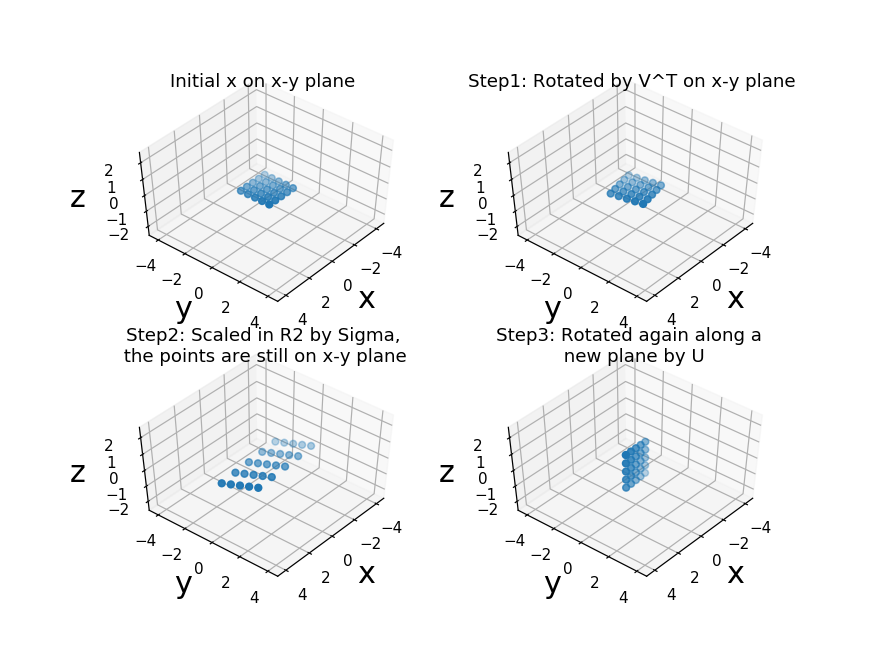

In [79]:
def geometric_interpret(A):
# This function plot the figures the original x, the rotated x, the rotate-and-streched x, 
# and the rotate-and-stretch-and-rotated x.
    
    # A must be a 3x2 matrix of rank 2, for visual convenience.
    m, n = A.shape
    r = np.ndim(A)
    assert (m, n, r) == (3, 2, 2)
    
    # Singular-value decomposition
    U, sigmas, VT = la.svd(A)
    Sigma = construct_Sigma(sigmas, A.shape)
    
    # Generate the grid points x. Note that a "point" denote a "vector"!
    density = 0.5
    x1, x2 = np.mgrid[slice(-1, 1 + density, density),
                     slice(-1, 1 + density, density)]

    x = np.c_[x1.flatten(), x2.flatten()].T
    
    # Calculate the transformation following the 3-step subprocess
    VTx = VT.dot(x)
    SigmaVTx = Sigma.dot(VTx)
    USigmaVtx = U.dot(SigmaVTx)

    # Zip the data and labels for iteration
    matrices = [np.c_[x.T, np.zeros((x.shape[1], 1))], np.c_[VTx.T, np.zeros((VTx.shape[1], 1))],
               SigmaVTx.T, USigmaVtx.T]
    strings = ["Initial x on x-y plane", "Step1: Rotated by V^T on x-y plane",
              "Step2: Scaled in R2 by Sigma,\n the points are still on x-y plane",
              "Step3: Rotated again along a \n new plane by U"]    
    all_stuffs = zip(matrices, strings)
    
    # Iteratively plot the four subplots.
    fig= plt.figure(figsize=(8,6))
    
    for i, (matrix, string) in enumerate(all_stuffs):
        
        ax = fig.add_subplot(2,2,i+1, projection='3d')
        ax.scatter(matrix[:,0],matrix[:,1], matrix[:,2])
        ax.set_xlim([-4.5, 4.5])
        ax.set_ylim([-4.5, 4.5])
        ax.set_zlim([-2.5, 2.5])
        ax.set_xlabel("x", fontsize=20)
        ax.set_ylabel("y", fontsize=20)
        ax.set_zlabel("z", fontsize=20)
        ax.view_init(elev=50, azim=40)
        plt.title(string)

#####################################################################################

# Define a matrix
A = np.array([[2, 0],
             [1, 0],
              [1, 1]], dtype=float)


geometric_interpret(A)

### Condition Number<a name="CN"></a>
[Return to Table of Content](#Table_of_Content)

There is one last minor point to cover today, the condition number! It is the ratio of the largest to smallest singular value in the SVD of a matrix, which is kind of easy compared to other perspectives of this demo :)

The condition number measures how sensitive the solution is to perturbations in the input data and to roundoff errors made during the solution process. A system is **ill-conditioned** if the condition number is too large. 

Let's see one ill-conditioned and one "very ill-conditioned" examples below.

In [80]:
# Define a matrix
A = np.array([[1, 2],
             [1, 2],
              [1, 2.001]], dtype=float)

# SVD
U, sigmas, VT = la.svd(A)
Sigma = construct_Sigma(sigmas, A.shape)
V = VT.T

print("A = \n", A)
print("U = \n", U)
print("Sigma = \n", Sigma)
print("V = \n", V)
print("The condition number = ", sigmas.max()/sigmas.min())

A = 
 [[1.    2.   ]
 [1.    2.   ]
 [1.    2.001]]
U = 
 [[-0.57727329 -0.40835714 -0.70710678]
 [-0.57727329 -0.40835714  0.70710678]
 [-0.5775042   0.81638771 -0.        ]]
Sigma = 
 [[3.87349982 0.        ]
 [0.         0.0003651 ]
 [0.         0.        ]]
V = 
 [[-0.44715396 -0.89445701]
 [-0.89445701  0.44715396]]
The condition number =  10609.430757773482


In [81]:
# Define a matrix
A = np.array([[1, 2],
             [1, 2],
              [1, 2]], dtype=float)

# SVD
U, sigmas, VT = la.svd(A)
Sigma = construct_Sigma(sigmas, A.shape)
V = VT.T

print("A = \n", A)
print("U = \n", U)
print("Sigma = \n", Sigma)
print("V = \n", V)
print("The condition number = ", sigmas.max()/sigmas.min())

A = 
 [[1. 2.]
 [1. 2.]
 [1. 2.]]
U = 
 [[-0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  0.78867513 -0.21132487]
 [-0.57735027 -0.21132487  0.78867513]]
Sigma = 
 [[3.87298335 0.        ]
 [0.         0.        ]
 [0.         0.        ]]
V = 
 [[-0.4472136  -0.89442719]
 [-0.89442719  0.4472136 ]]
The condition number =  inf


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app


### Pseudo Inverse<a name="PI"></a>
[Return to Table of Content](#Table_of_Content)

The pseudo inverse is a generalized version of vanilla inverse, because it can work on any rectangle matrices, in addition to square matrices. `numpy.linalg.pinv()` is an existing method for calculating the pseudo inverse.

Today we can finally derive the pseudo inverse thanks to the SVD! And the derivation is simple. Recall that $U$ and $V$ are unitary matrices, so that $U^T=U^{-1}$ and $V^T=V^{-1}$, and $UU^T=U^TU=I$ and $VV^T=V^TV=I$, we have

$$
\begin{align}
A\hat{x} &= b \\
U\Sigma V^T\hat{x} &=b\\
A^{-1}A\hat{x} &= A^{-1}b\\
V\Sigma^{-1}U^TU\Sigma V^T\hat{x}&=V\Sigma^{-1}U^Tb\\
\hat{x}&=V\Sigma^{-1}U^Tb\\
&=A^+b\\
A^+&=V\Sigma^{-1}U^T
\end{align}
$$

And, considering that only the first $r$ columns of $U$ and $V$ have contribution to the transformation, we can further simplify the formula to:

$$
\begin{equation}
A^+=V_r\Sigma^{-1}_rU^T_r
\label{eq:pseudo}
\end{equation}
$$

Let's examine Eq. \eqref{eq:pseudo} to see whether it is identical to `numpy.linalg.pinv()`.

In [82]:
# Define a matrix
A = np.array([[2, 0],
             [1, 0],
              [1, 1]], dtype=float)
r = np.ndim(A)

# SVD
U, sigmas, VT = la.svd(A)
V = VT.T
Sigma = np.diag(sigmas)

# Manually compute the pseudo inverse following Eq. 27
A_pseudo_inv_manual = V[:,:r].dot(la.inv(Sigma[:,:r])).dot(U[:, :r].T)

# Use existing routine
A_pseudo_inv_machine = la.pinv(A)

print("Manual equals Machine?\n", np.allclose(A_pseudo_inv_manual, A_pseudo_inv_machine))

Manual equals Machine?
 True


### Takeaways<a name="Takeaways"></a>
[Return to Table of Content](#Table_of_Content)

1. The mechanics (what/how) is not important, but the big picture (why) matters, especially for today.
2. Prof Strang's [four fundamental spaces](https://ww2.mathworks.cn/en/videos/differential-equations-and-linear-algebra-55-the-big-picture-of-linear-algebra-117460.html) and [SVD](https://www.youtube.com/watch?v=rYz83XPxiZo) are two must-see videos for today's topic.
3. Theoretically, for a SVD $A=U\Sigma V^{T}$, you can obtain $U$ and $V$ by carrying out EVD on $A^TA=U\Sigma^2 U^{-1}$ and $AA^T=V\Sigma^2 V^{-1}$, respectively, and finally reconstruct $A$ again.  However, you may find that the eigenvectors obtained by using `la.eig(ATA)` and `la.eig(AAT)` do not match with that from `la.svd(A)`. The reason is that, the two EVD on $A^TA$ and $AA^T$ are done separately, and hence the eigenvectors in $U$ and $V$ may have opposite direction. Also, `la.eig()` does not sort the eigenvalues, while `la.svd()` does sort and hence reorders vectors. A more detailed explanatin is provided at [this link](https://stackoverflow.com/questions/56736928/numpy-why-does-np-linalg-eig-and-np-linalg-svd-give-different-v-values-of-svd).

### Practice<a name="Practice"></a>
[Return to Table of Content](#Table_of_Content)

1. Define a routine `A_plus = my_pinv(A)` by encapsulate relevant code from this demo, which produces the pseudo inverse of `A` following Eq. 27.
2. Verify your routine above can produce the same result with that from `la.pinv()` of Numpy.
3. Define a routine `condition_num = my_cn(A)` by encapsulate relevant code from this demo, which calculates the condition number of `A`.
4. For a SVD $A=U\Sigma V^{T}$, which columns from $U$ and $V$ are the most important?
5. If we  "ingredient-recipe" theory:
    + If we take $U$ as the recipe, then what are the ingredients?
        + Is it the rows of $A$?
    + If we take $V$ as the recipe, then what are the ingredients?
        + Is it the columns of $A$?